# Computational modeling : likelihood for various RL agents

Question : under very low amounts of evidence, how do human sample a complex action space ? Can we infer some form of structure in this exploration ? Can Active Inference provide some answers regarding the mechanistic processes behind it ?

In notebook 103, we derived a few proposal models to explain the behaviour of our subjects.  However, this is not enough as we aim at performing model inversion based on task data ! This means that we're going to need **likelihood functions** for each of these models !

Likelihood function describe the probability of these models generating the observed actions, given their hyperparameters $\theta$ and their previous experiences $o_{1:T,1:t},s_{1:T,1:t}$ : 
$$
\prod_T \prod_{t\in T} P(u_t|o_{1:T,1:t},u_{1:T,1:t-1},\theta)
$$

In this notebook, we modify the previous models to compute their likelihood in a jax environment.

In [2]:
# Import the needed packages 
# 
# 1/ the usual suspects
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap


from functools import partial

# 2/ The Active Inference package 
import actynf
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog
from actynf.jaxtynf.layer_trial import compute_step_posteriors
from actynf.jaxtynf.layer_learn import learn_after_trial
from actynf.jaxtynf.layer_options import get_learning_options,get_planning_options
from actynf.jaxtynf.shape_tools import to_log_space,get_vectorized_novelty

from actynf.jaxtynf.layer_process import initial_state_and_obs,process_update
from actynf.jaxtynf.shape_tools import vectorize_weights


# 3/ Tools for : 
# a. Getting the raw data : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
# b. Preprocessing the data :
from analysis_tools.preprocess import OPTIONS_PREPROCESS_DEFAULT,get_preprocessed_data



# The environment is statically defined by its HMM matrices : 
from simulate.hmm_weights import behavioural_process
# Weights for the active inference model : 
from simulate.hmm_weights import basic_latent_model


# To generate synthetic data :
from simulate.generate_observations import TrainingEnvironment,run_loop



c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's instantitate some agents and generate some synthetic data for the random agent only. Our goal here is to compute,for each model, the likelihood of having performed the actions seen here for a given set of parameters.

In [3]:
# The synthetic environment CONSTANTS :
T = 11
N_FEEDBACK_OUTCOMES = 10
TRUE_FEEDBACK_STD = 0.15
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)
rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(rngkey,a,b,c,d,e,u,T)


# In : an agent based on some hyperparameters : 
from agents.basic_agents import random_agent
SEED = 100
NTRIALS = 10
random_agent_hyperparameters = None
random_agent_constants = (9,)

# Synthetic data (here, generated randomly) :
params_final,training_hist = run_loop(ENVIRONMENT,random_agent(random_agent_hyperparameters,random_agent_constants),SEED,NTRIALS)
# Parameter update (once every trial)
def _swaplist(_list):
    """ Put the various factors / modalities as the leading dimension for a 2D list of lists."""
    if _list is None :
        return None
    
    for el in _list :
        if (type(el) != list) and (type(el) != tuple):
            # There is a single factor here ! 
            return _list
    
    _swapped_list = []
    for factor in range(len(_list[0])):
        _swapped_list.append([_el[factor] for _el in _list])
    return _swapped_list
        
        
formatted_stimuli= [jnp.array(o) for o in _swaplist(training_hist["stimuli"])]
bool_stimuli = [jnp.ones_like(stim[...,0]) for stim in formatted_stimuli]
rewards = jnp.array(training_hist["rewards"])
SYNTHETIC_ACTIONS = jnp.array(training_hist["actions"])
tmtsp = jnp.array(training_hist["timestamps"])
SYNTHETIC_DATA = (formatted_stimuli,bool_stimuli,rewards,SYNTHETIC_ACTIONS,tmtsp)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


Here is the generic function that will help us compute the training likelihood. Our goal is to make it work for all kinds of agents implementing the key (parametric) methods : init_params,init_state,agent_learn and predict !

In [10]:

def compute_predicted_actions(data,agent_functions):
    """A function that uses vmap to compute the predicted agent action at time $t$ given $o_{1:t}$ and $u_{1:t-1}$. 
    This function should be differentiable w.r.t. the hyperparameters of the agent's model because we're going to perform
    gradient descent on it !

    Args:
        environment (_type_): _description_
        agent_functions (_type_): _description_
        seed (_type_): _description_
        Ntrials (_type_): _description_

    Returns:
        _type_: _description_
    """
    init_params,init_state,_,agent_learn,predict,_ = agent_functions
    
    
    # Data should contain :
    # - all observations -> stimuli,reward (from the system)
    #       -> a list of stimuli for each modality
    #       -> a list of observation filters for each modality
    #       -> a Ntrials x Ntimesteps tensor array of scalar rewards (\in [0,1])
    # - all true actions 
    #       -> a Ntrials x (Ntimesteps-1) x Nu tensor array encoding the observed actions
    #       -> a Ntrials x (Ntimesteps-1) filter tensor indicating which actions were NOT observed
    
    initial_parameters = init_params()  
        # The initial parameters of the tested model are initialized once per training
    
    
    def _scan_trial(_carry,_data_trial):
        
        _agent_params = _carry
        _initial_state = init_state(_agent_params)
        
        _observations_trial,_observations_filter_trial,_rewards_trial,_actions_trial,_timestamps_trial = _data_trial
        
        # The same actions, with an extra one at the end for scan to work better !
        _expanded_actions_trial = jnp.concatenate([_actions_trial,jnp.zeros((1,_actions_trial.shape[-1]))])
        _expanded_data_trial = (_observations_trial,_observations_filter_trial,_rewards_trial,_expanded_actions_trial,_timestamps_trial)
        
        def __scan_timestep(__carry,__data_timestep):
            # __obs_vect,__obs_bool,__reward,__true_action_vect,__t = __data_timestep
            __agent_state = __carry
                    
            __new_state,__predicted_action,__other_data = predict(__data_timestep,__agent_state,_agent_params)        
            
            return __new_state,(__predicted_action,__new_state,__other_data)
        
        
        
        _,(_predicted_actions,_trial_states,_trial_other_data) = jax.lax.scan(__scan_timestep, (_initial_state),_expanded_data_trial)
          
        
        _new_params = agent_learn((_rewards_trial,_observations_trial,_trial_states,_actions_trial),_agent_params)
        
        return _new_params,(_predicted_actions[:-1,...],(_trial_states,_trial_other_data))

    final_parameters,(predicted_actions,(model_states,other_data)) = jax.lax.scan(_scan_trial,initial_parameters,data)

    return final_parameters,predicted_actions,(model_states,other_data)






# Example :  compute the likelihood of each action given the random model : 
final_parameters,predicted_actions,model_states = compute_predicted_actions(SYNTHETIC_DATA,random_agent(random_agent_hyperparameters,random_agent_constants))
print(predicted_actions)
# print(model_states)

# Here's the average log-likelihood of what was observed given this model :
avg_ll = jnp.mean((SYNTHETIC_ACTIONS * _jaxlog(predicted_actions)).sum(axis=-1))
print(avg_ll)


[[[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
   0.11111111 0.11111111 0.11111111]
  [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
   0.11111111 0.11111111 0.11111111]
  [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
   0.11111111 0.11111111 0.11111111]
  [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
   0.11111111 0.11111111 0.11111111]
  [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
   0.11111111 0.11111111 0.11111111]
  [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
   0.11111111 0.11111111 0.11111111]
  [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
   0.11111111 0.11111111 0.11111111]
  [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
   0.11111111 0.11111111 0.11111111]
  [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
   0.11111111 0.11111111 0.11111111]
  [0.11111111 0.11111111 0.11111111 0.11111111

In [12]:
from agents.basic_agents import choice_kernel_agent

ck_agent_hyperparameters = (0.5,10.0)   # [0,1] x [0, +oo]
ck_agent_constants = (9,)              # Nactions
final_parameters,predicted_actions,state_history = compute_predicted_actions(SYNTHETIC_DATA,choice_kernel_agent(ck_agent_hyperparameters,ck_agent_constants))
# print(predicted_actions)


# We can have an idea of what happened during training by looking at the inner states of the model
inner_states,_ = state_history
# Of course, these will vary from one model to the next :
ck_table,previous_action = inner_states
print(ck_table.shape)
print(ck_table[-1,-1,:])

# Here's the average log-likelihood of what was observed given this model :
avg_ll = jnp.mean((SYNTHETIC_ACTIONS * _jaxlog(predicted_actions)).sum(axis=-1))
print(avg_ll)


(10, 11, 9)
[9.7656250e-03 1.0768622e-03 4.0283222e-03 2.5001526e-01 2.4414156e-04
 4.8834115e-04 5.0000000e-01 5.7220791e-06 2.3437572e-01]
-4.498164


A very "strict" choice kernel agent is very unlikely for this data (which makes sense, as it was randomly generated ! )

In [14]:
from agents.basic_agents import rescorla_wagner_agent

rw_agent_hyperparameters = (0.5,10.0)
rw_agent_constants = (9,)
final_parameters,predicted_actions,state_history = compute_predicted_actions(SYNTHETIC_DATA,rescorla_wagner_agent(rw_agent_hyperparameters,rw_agent_constants))
print(predicted_actions)


# We can have an idea of what happened during training by looking at the inner states of the model
inner_states,_ = state_history
# Of course, these will vary from one model to the next :
q_table,previous_action = inner_states
print(q_table.shape)
print(q_table[-1,-1,:])

# Here's the average log-likelihood of what was observed given this model :
avg_ll = jnp.mean((SYNTHETIC_ACTIONS * _jaxlog(predicted_actions)).sum(axis=-1))
print(avg_ll)

[[[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
   0.11111111 0.11111111 0.11111111]
  [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
   0.11111111 0.11111111 0.11111111]
  [0.09059832 0.09059832 0.2752134  0.09059832 0.09059832 0.09059832
   0.09059832 0.09059832 0.09059832]
  [0.10263875 0.10263875 0.17889002 0.10263875 0.10263875 0.10263875
   0.10263875 0.10263875 0.10263875]
  [0.10263875 0.10263875 0.17889002 0.10263875 0.10263875 0.10263875
   0.10263875 0.10263875 0.10263875]
  [0.10729392 0.10729392 0.14164865 0.10729392 0.10729392 0.10729392
   0.10729392 0.10729392 0.10729392]
  [0.11561515 0.11561515 0.15263428 0.11561515 0.11561515 0.11561515
   0.11561515 0.11561515 0.03805969]
  [0.05925152 0.05925152 0.07822344 0.05925152 0.54676217 0.05925152
   0.05925152 0.05925152 0.01950518]
  [0.05925152 0.05925152 0.07822344 0.05925152 0.54676217 0.05925152
   0.05925152 0.05925152 0.01950518]
  [0.10647024 0.10647024 0.14056127 0.10647024

In [16]:
from agents.basic_agents import rw_ck_agent

rw_ck_agent_hyperparameters = (0.1,10.0,0.5,0.1)
rw_ck_agent_constants = (9,)
final_parameters,predicted_actions,state_history = compute_predicted_actions(SYNTHETIC_DATA,rw_ck_agent(rw_ck_agent_hyperparameters,rw_ck_agent_constants))

# We can have an idea of what happened during training by looking at the inner states of the model
inner_states,_ = state_history
# Of course, these will vary from one model to the next :
q_table,ck_table,previous_action = inner_states
print(q_table.shape)
print(q_table[-1,-1,:])
print(ck_table[-1,-1,:])

# Here's the average log-likelihood of what was observed given this model :
avg_ll = jnp.mean((SYNTHETIC_ACTIONS * _jaxlog(predicted_actions)).sum(axis=-1))
print(avg_ll)


(10, 11, 9)
[ 0.03156808  0.04391102  0.11929256 -0.01553993  0.02575896  0.07111171
 -0.0330379  -0.06475359 -0.00941168]
[9.7656250e-03 1.0768622e-03 4.0283222e-03 2.5001526e-01 2.4414156e-04
 4.8834115e-04 5.0000000e-01 5.7220791e-06 2.3437572e-01]
-2.2950704


In [17]:
from agents.basic_agents import q_learning_agent

ql_ck_agent_hyperparameters = (0.5,0.7,1.0,0.0,0.0)
ql_ck_agent_constants = (9,N_FEEDBACK_OUTCOMES)
final_parameters,predicted_actions,state_history = compute_predicted_actions(SYNTHETIC_DATA,q_learning_agent(ql_ck_agent_hyperparameters,ql_ck_agent_constants))

# We can have an idea of what happened during training by looking at the inner states of the model
inner_states,_ = state_history
# Of course, these will vary from one model to the next :
q_table,ck_table,previous_action,previous_stim = inner_states
print(q_table.shape)
print(q_table[-1,-1,:])
print(ck_table[-1,-1,:])

# Here's the average log-likelihood of what was observed given this model :
avg_ll = jnp.mean((SYNTHETIC_ACTIONS * _jaxlog(predicted_actions)).sum(axis=-1))
print(avg_ll)

(10, 11, 9, 10)
[[ 0.          0.09333334  0.1977778  -0.07777778 -0.15555556  0.
   0.          0.          0.          0.        ]
 [ 0.22        0.11111112 -0.03644444  0.04666667 -0.17777778 -0.15555556
   0.05555555  0.          0.          0.        ]
 [ 0.1         0.19911112 -0.04444444  0.05555555  0.          0.
   0.05555555  0.          0.          0.        ]
 [ 0.          0.          0.00124444 -0.06222223  0.11111112  0.
   0.          0.          0.          0.        ]
 [ 0.         -0.04444444 -0.1777778  -0.07777778 -0.03333333  0.07111112
   0.          0.          0.          0.        ]
 [ 0.2         0.14506668  0.         -0.23333333  0.16666667  0.
  -0.23333333  0.          0.          0.        ]
 [ 0.1         0.         -0.06533334 -0.07777778 -0.15555556  0.
   0.          0.          0.          0.        ]
 [ 0.          0.11111112 -0.15555556  0.01617778 -0.07777777 -0.3888889
   0.         -0.03111111  0.          0.        ]
 [ 0.01111111  0.05555556

In [5]:
from agents.basic_agents import active_inference_basic_1D


# We get a model weights by defining a "parameters" object :
aif_1d_constants = {
    # General environment : 
    "N_feedback_ticks":N_FEEDBACK_OUTCOMES,
    # Latent state space structure
    "Ns_latent":5,      # For 1D
    # Action discretization:
    "N_actions" :9,
    
    "Th" : 3,
    
    "learn_e" : True
}

aif_1d_params = {    
    # ----------------------------------------------------------------------------------------------------
    # Model parameters : these should interact with the model components in a differentiable manner
    "transition_concentration": 1.0,
    "transition_stickiness": 1.0,
    "transition_learning_rate" : 1.0,
    "state_interpolation_temperature" : 1.0,
    
    "initial_state_concentration": 1.0,
    
    "feedback_expected_std" : 0.15,
    "emission_concentration" : 1.0,
    "emission_stickiness" : 100.0,
    
    "reward_seeking" : 10.0,
    "habits_learning_rate" : 0.3,
    
    "action_selection_temperature" : 10.0,
}
final_parameters,predicted_actions,state_history = compute_predicted_actions(SYNTHETIC_DATA,active_inference_basic_1D(aif_1d_params,aif_1d_constants))
# print(predicted_actions)


# We can have an idea of what happened during training by looking at the inner states of the model
inner_states,(infered_states,free_energies) = state_history
# Of course, these will vary from one model to the next :
priors,posteriors,weights = inner_states

# a_norm,b_norm,c,e,a_novel,b_novel = weights

print(free_energies)
print(free_energies.shape)

# print(q_table.shape)
# print(q_table[-1,-1,:])
# print(ck_table[-1,-1,:])

# Here's the average log-likelihood of what was observed given this model :
avg_ll = jnp.mean((SYNTHETIC_ACTIONS * _jaxlog(predicted_actions)).sum(axis=-1))
print(avg_ll)

NameError: name 'compute_predicted_actions' is not defined

For the remainder of the study, we'll stock all of these predictive models in the [proposal models](./proposal_models.py) file to manipulate and change them more easily. Next up is inversion !




## Parameter recoverability : 

When do the parameters of our complex Active Inference model lead to results undistinguishable from a random agent ?

We perform N Monte Carlo simulations of an Active Inference agent training. We compute the log-likelihood of the (actual) parameters. We then compare the log likelihood of the data for the null model and the Active Inference model (with its true parameters).

Then --> https://fr.wikipedia.org/wiki/Test_du_rapport_de_vraisemblance

In [43]:
from simulate.compute_likelihood import compute_loglikelihood
from simulate.generate_observations import generate_synthetic_data
import tensorflow_probability.substrates.jax.distributions as tfd




# We get a model weights by defining a "parameters" object :
aif_1d_constants = {
    # General environment : 
    "N_feedback_ticks":N_FEEDBACK_OUTCOMES,
    # Latent state space structure
    "Ns_latent":5,      # For 1D
    # Action discretization:
    "N_actions" :9,
    
    "Th" : 3,
    
    "learn_e" : True
    
}
tested_agent = partial(active_inference_basic_1D,constants=aif_1d_constants)


aif_1d_params = {    
    # ----------------------------------------------------------------------------------------------------
    # Model parameters : these should interact with the model components in a differentiable manner
    "transition_concentration": 1.0,
    "transition_stickiness": 1.0,
    "transition_learning_rate" : 1.0,
    "state_interpolation_temperature" : 1.0,
    
    "initial_state_concentration": 1.0,
    
    "feedback_expected_std" : 0.15,
    "emission_concentration" : 1.0,
    "emission_stickiness" : 10.0,
    
    "reward_seeking" : 10.0,
    
    "habits_learning_rate" : 0.3,
    
    "action_selection_temperature" : 10.0,
}


Ntrials = 10
tested_params = aif_1d_params
SUBJ_DATA = generate_synthetic_data(ENVIRONMENT,tested_agent(tested_params),Ntrials,20,False)
ll = compute_loglikelihood(SUBJ_DATA,tested_agent(tested_params),"sum")
    
static_params_rng_agent = (9,)
rng_agent = partial(random_agent,constants=static_params_rng_agent)
null_ll = compute_loglikelihood(SUBJ_DATA,rng_agent(None),"sum")

print(ll,null_ll)
# # Ground truth data generation
# N = 1000
# gt_parameters_sample_dist = {
#     # ----------------------------------------------------------------------------------------------------
#     # Model parameters : these should interact with the model components in a differentiable manner
#     "transition_concentration": tfd.Uniform(low=0.01,high=10.0), # Initial concentrations should be rather low
#     "transition_stickiness": tfd.Uniform(low=0.01,high=10.0),
#     "transition_learning_rate" : tfd.Uniform(low=0.01,high=10.0),
#     "state_interpolation_temperature" :tfd.Uniform(low=0.01,high=10.0),
    
#     "initial_state_concentration": tfd.Uniform(low=0.01,high=10.0),
    
#     "feedback_expected_std" : tfd.Uniform(low=0.0,high=1.0),
#     "emission_concentration" : tfd.Normal(1.0,1.0),
#     "emission_stickiness" : tfd.Normal(100.0,1.0),
    
#     "reward_seeking" : tfd.Normal(10.0,1.0),
    
#     "action_selection_temperature" :  tfd.Normal(10.0,1.0),
# }
# def sample_data(rng_key,dist_dict):
#     sampled_values = {}
#     for key, d in dist_dict.items():
#         rng_key,d_key = jr.split(rng_key)
#         sampled_values[key] = jnp.array(d.sample(seed = d_key))
#     return sampled_values

# all_lls = [None]
# all_params = []
# for point_sample in range(N):
    
#     rngkey,p_rng = jr.split(rngkey)
#     tested_params = sample_data(p_rng,gt_parameters_sample_dist)
#     all_params.append(np.fromiter(tested_params.values(), dtype=float))
    
#     print("{}/{}".format(point_sample+1,N))
#     SUBJ_DATA = generate_synthetic_data(ENVIRONMENT,tested_agent(tested_params),10,20,False)
#     print(all_lls[-1])
#     ll = compute_loglikelihood(SUBJ_DATA,tested_agent(tested_params),"sum")
#     all_lls.append(ll)
    
# static_params_rng_agent = (9,)
# rng_agent = partial(random_agent,constants=static_params_rng_agent)
# null_ll = compute_loglikelihood(SUBJ_DATA,rng_agent(None),"sum")

    
# print(all_lls)
# print(all_params)
# print(null_ll)

(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
-153.10977 -219.72247


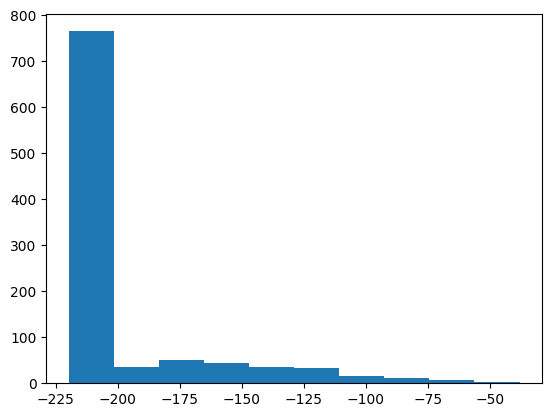

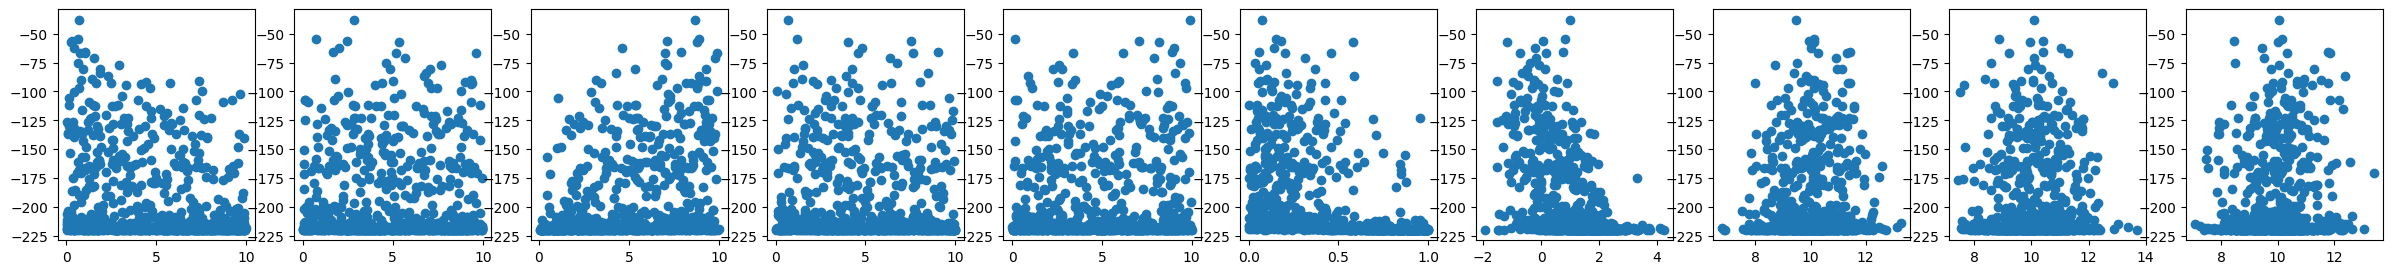

In [34]:

ll_arr = (np.array(all_lls[1:]))
param_arr = np.array(all_params)
plt.hist(ll_arr)


Nparams = param_arr.shape[-1]
fig,axs = plt.subplots(1,Nparams,figsize=(3*Nparams,3))
for key in range(Nparams):
    axs[key].scatter(param_arr[:,key],ll_arr)